# Benchmarking Neighbor Finding against scipy
The neighbor finding algorithms in freud are highly efficient and rely on parallelized C++ code. Below, we show a benchmark of freud's `AABBQuery` algorithm against the `scipy.spatial.cKDTree`. This benchmark was run on an Intel(R) Xeon(R) i3-8100B CPU @ 3.60GHz.

In [1]:
import timeit

import freud
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
from tqdm.notebook import tqdm

In [2]:
def make_scaled_system(N, Nneigh=12):
    L = (4 / 3 * np.pi * N / Nneigh) ** (1 / 3)
    return freud.data.make_random_system(L, N)


box, points = make_scaled_system(1000)

## Timing Functions

In [3]:
def time_statement(stmt, repeat=5, number=100, **kwargs):
    timer = timeit.Timer(stmt=stmt, globals=kwargs)
    times = timer.repeat(repeat, number)
    return np.mean(times), np.std(times)

In [4]:
def time_scipy_cKDTree(box, points):
    shifted_points = points + np.asarray(box.L) / 2
    # SciPy only supports cubic boxes
    assert box.Lx == box.Ly == box.Lz
    assert box.xy == box.xz == box.yz == 0
    return time_statement(
        "kdtree = scipy.spatial.cKDTree(points, boxsize=L);"
        "kdtree.query_ball_tree(kdtree, r=rcut)",
        scipy=scipy,
        points=shifted_points,
        L=box.Lx,
        rcut=1.0,
    )

In [5]:
def time_freud_AABBQuery(box, points):
    return time_statement(
        "aq = freud.locality.AABBQuery(box, points);"
        "aq.query(points, {'r_max': r_max, 'exclude_ii': False}).toNeighborList()",
        freud=freud,
        box=box,
        points=points,
        r_max=1.0,
    )

In [6]:
# Test timing functions
kd_t = time_scipy_cKDTree(box, points)
print(kd_t)
abq_t = time_freud_AABBQuery(box, points)
print(abq_t)

(0.6436181232333184, 0.008598492136056879)
(0.09153120275586843, 0.00780408130095089)


## Perform Measurements

In [7]:
def measure_runtime_scaling_N(Ns, r_max=1.0):
    result_times = []
    for N in tqdm(Ns):
        box, points = make_scaled_system(N)
        result_times.append(
            (time_scipy_cKDTree(box, points), time_freud_AABBQuery(box, points))
        )
    return np.asarray(result_times)

In [8]:
def plot_result_times(result_times, Ns):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
    ax.plot(
        Ns,
        result_times[:, 0, 0] / 100,
        "o",
        linestyle="-",
        markersize=5,
        label=f"scipy v{scipy.__version__} cKDTree",
    )

    ax.plot(
        Ns,
        result_times[:, 1, 0] / 100,
        "x",
        linestyle="-",
        markersize=5,
        c="#2ca02c",
        label=f"freud v{freud.__version__} AABBQuery",
    )
    ax.set_xlabel(r"Number of points", fontsize=15)
    ax.set_ylabel(r"Runtime (s)", fontsize=15)
    ax.legend(fontsize=15)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", labelsize=12)
    fig.tight_layout()

    return fig, ax

In [9]:
# Use geometrically-spaced values of N, rounded to one significant figure
Ns = list(
    sorted(
        set(
            map(
                lambda x: int(round(x, -int(np.floor(np.log10(np.abs(x)))))),
                np.exp(np.linspace(np.log(50), np.log(5000), 10)),
            )
        )
    )
)

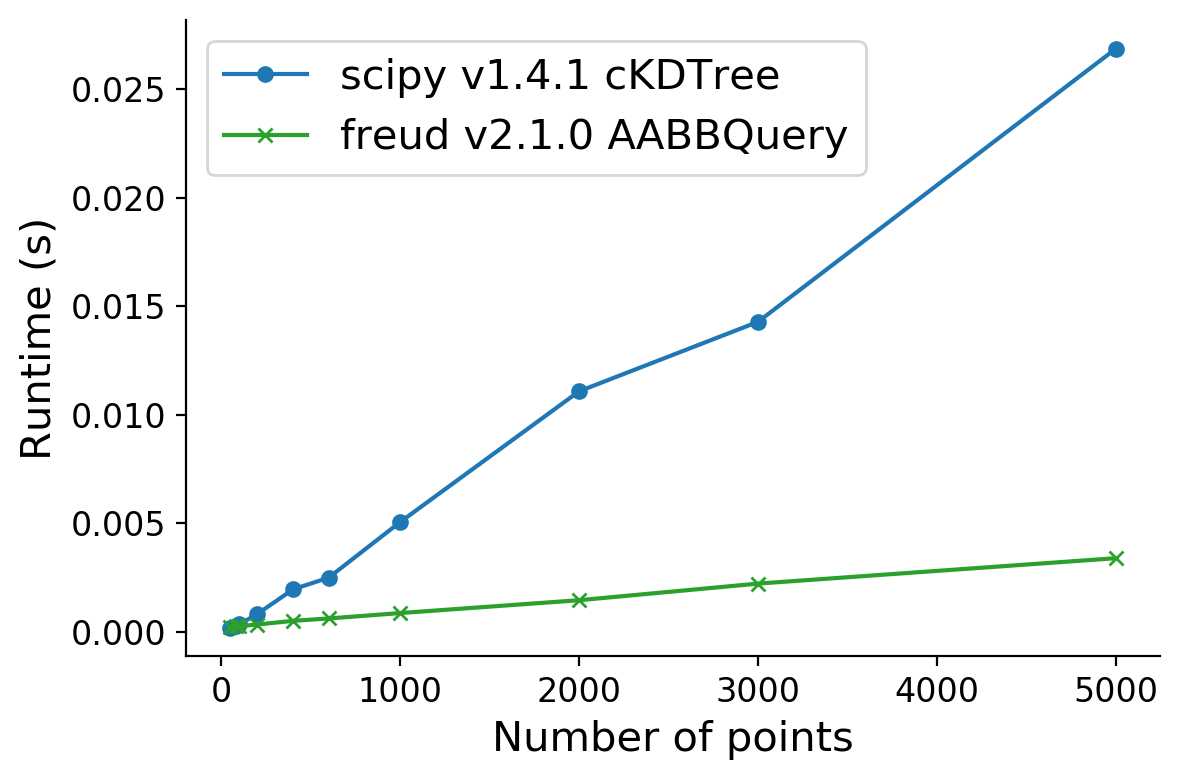

In [10]:
result_times = measure_runtime_scaling_N(Ns)
fig, ax = plot_result_times(result_times, Ns)